## Defining Cost and Mixer Hamiltonians based on the following definitions
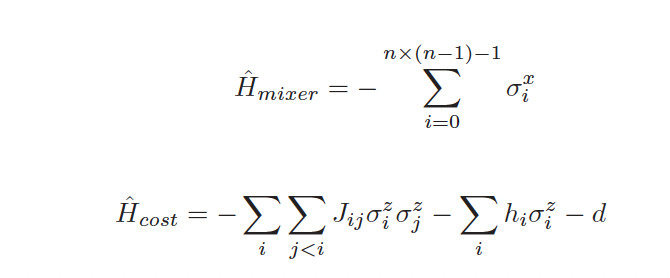

## Preparing the variables needed for the cost hamiltonian
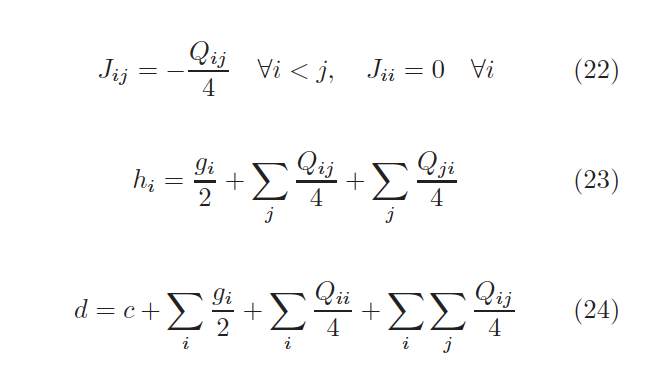

## Preparing the mixer hamiltonian

## Preparing the cost hamiltonian
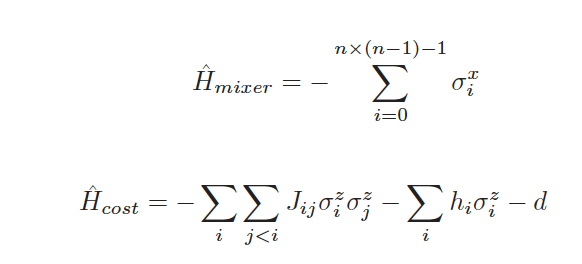

Binary Solution: [0 0 0 1 1 0 0 0 1 1 0 1]
Solution Cost: 123.02
Translated Solution (Edges): [(1, 0), (1, 2), (2, 3), (3, 0), (3, 2)]
The index with the highest probability is: 397


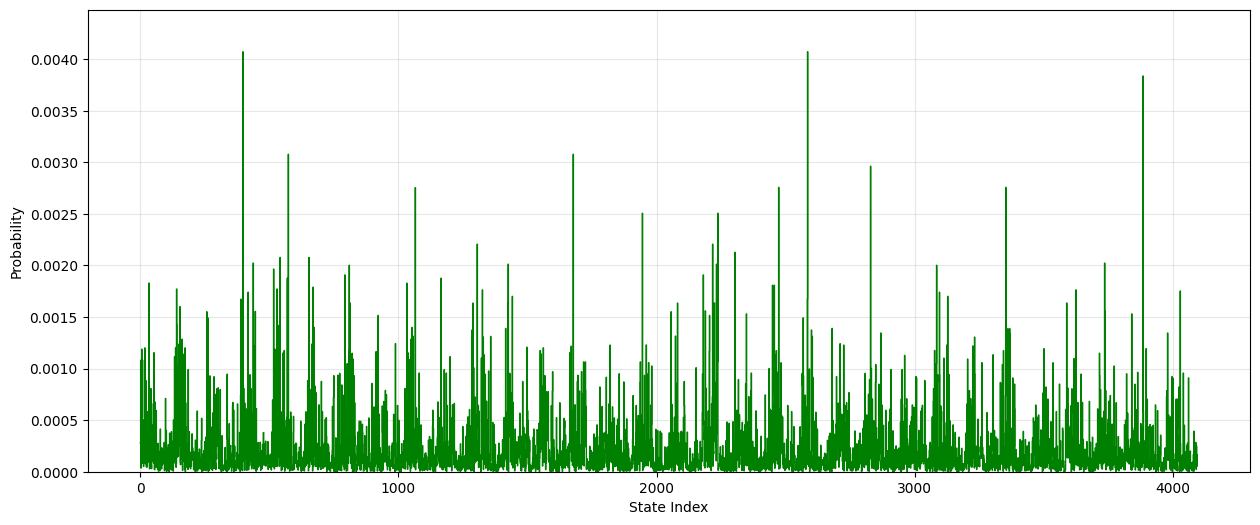

In [9]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import math
from matplotlib import pyplot as plt
import networkx as nx
from scipy.optimize import minimize

class VRPQAOA:
    def __init__(self, n, k, distance_matrix):
        """
        n: number of nodes
        k: number of vehicles
        distance_matrix: matrix of distances between nodes
        """
        self.n = n
        self.k = k
        self.distance_matrix = distance_matrix
        self.num_of_qubits = n*(n-1)
        self.A = 2
        # Number of layers (precision)
        self.p = 12
        self.wires = range(self.num_of_qubits)
        self.dev = qml.device("default.qubit", wires=self.num_of_qubits)


    # Preparing the elementary variables    
    
    def get_x_vector(self):
        """
        uses: self.distance_matrix
        size: (n*(n-1)) By 1

        Returns:

        x_vector: vector of binary decision variables representing the edges
        """
        # The total number of possible edges in a directed graph with n nodes is n*(n-1).
        x_vector = np.zeros(self.num_of_qubits)

        # Fill the vector with placeholders for the binary variables
        # Placeholder: Each x_ij corresponds to an index in the vector
        for i in range(self.n):
            for j in range(self.n):
                if (i != j and self.distance_matrix[i][j]!=0):  # Avoid self-loops (i.e., no edges from a node to itself)
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    x_vector[index] = 1  # Assign a binary variable placeholder

        return x_vector
    

    # this places a 1 even if there is no edge connecting between the nodes
    def get_z_source(self, source_index):
        """
        Args:
            index: int, the index of the source node
        size: (n*(n-1)) By 1
        Returns:

        z_source: vector of binary decision variables representing the source node
        """
        z_source = np.zeros(self.num_of_qubits)

        # Fill the vector with placeholders for the binary variables
        for i in range(self.n):
            for j in range(self.n):
                if (i == source_index and i != j):
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    z_source[index] = 1  # Assign a binary variable placeholder
        
        return z_source
    
    def get_z_target(self, target_index):
        """
        size: (n*(n-1)) By 1
        Returns:

        z_sink: vector of binary decision variables representing the sink/target node
        """
        z_target = np.zeros(self.num_of_qubits)

        # Fill the vector with placeholders for the binary variables
        for i in range(self.n):
            for j in range(self.n):
                if (j == target_index and i != j):
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    z_target[index] = 1  # Assign a binary variable placeholder
        
        return z_target
    

    # assuming if distance matrix contains 0 in some places then the weight of that would be 0
    def get_w_vector(self):
        """
        uses: self.distance_matrix
        size: (n*(n-1)) By 1
        Returns:

        w_vector: vector of weights, representing the distance from node i to j
        """
        w_vector = np.zeros(self.num_of_qubits)

        # Fill the vector with the distances
        for i in range(self.n):
            for j in range(self.n):
                if (i != j):
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    w_vector[index] = self.distance_matrix[i][j]

        return w_vector
    
    def get_Q(self):
        """
        Returns the quadratic coefficient matrix Q representing edge weights/interactions between nodes.
        Q is calculated as A * sum(outer_product(z_s[i], z_s[i]) + outer_product(z_t[i], z_t[i]))
        where z_s[i] and z_t[i] are the source and target vectors for node i.
        
        Returns:
            numpy.ndarray: A square matrix of size (n*(n-1)) x (n*(n-1))
        """
        # Initialize Q matrix with zeros
        Q = np.zeros((self.num_of_qubits, self.num_of_qubits))
        
        # Sum over all nodes (n-1 as per the formula)
        for i in range(self.n):
            # Get z vectors for source and target
            z_source = self.get_z_source(i)
            z_target = self.get_z_target(i)
            
            # Calculate outer products
            # Reshape vectors to column vectors for outer product
            z_source_reshaped = z_source.reshape(-1, 1)
            z_target_reshaped = z_target.reshape(-1, 1)
            
            # Add outer products to Q
            Q += np.dot(z_source_reshaped, z_source_reshaped.T)
            Q += np.dot(z_target_reshaped, z_target_reshaped.T)
        
        # Multiply by coefficient A
        Q *= self.A
        
        return Q

    # not reshaped
    def get_helper_J(self):
        """
        Returns:
            vector used in calculation of g
        """
        
        J = np.zeros(self.num_of_qubits)
        for i in range(1, self.n):
            J+= self.get_z_source(i)
        return J
    
    # not reshaped
    def get_helper_K(self):
        """
        Returns:
            vector used in calculation of g
        """
        K = np.zeros(self.num_of_qubits)
        for i in range(1, self.n):
            K+= self.get_z_target(i)
        return K

    # not reshaped
    def get_g(self):
        """
        Returns:

        g: the linear coefficient g which represents the node weight i.e.,
        contribution from individual nodes

        """
        w_vector = self.get_w_vector()
        z_source = self.get_z_source(0)
        z_target = self.get_z_target(0)
        g = w_vector - 2*self.A*self.k*(z_source + z_target) - 2*self.A*(self.get_helper_J() + self.get_helper_K())
        return g.T
    

    def get_c(self):
        """
        Returns:

        c: constant offset

        """        
        return (2*self.A*(self.n-1))+(2*self.A*math.pow(self.k, 2))


    # Preparing the variables needed for the cost hamiltonian

    def get_J_Matrix(self):
        """
        size: (n*(n-1)) By (n*(n-1))
        Returns:

        J: where J is a matrix to keep track of the interactions
        """
        J = np.zeros((self.num_of_qubits, self.num_of_qubits))
        for i in range(self.num_of_qubits):
            for j in range(self.num_of_qubits):
                if(i<j):
                    J[i][j] = -self.get_Q()[i][j]/4
        return J

    # not sure about how summation rules translated correctly
    def get_h_vector(self):
        """
        Implements h_i = g_i/2 + sum_j(Q_ij/4) + sum_j(Q_ji/4)
        
        Returns:
            numpy.ndarray: Vector of linear coefficients
        """
        # Get necessary components
        g = self.get_g()
        Q = self.get_Q()
        
        # Initialize h vector
        h = np.zeros(self.num_of_qubits)
        
        # Calculate h_i for each i
        for i in range(self.num_of_qubits):
            # First term: g_i/2
            h[i] = g[i] / 2
            
            # Second term: sum_j(Q_ij/4)
            h[i] += np.sum(Q[i, :]) / 4
            
            # Third term: sum_j(Q_ji/4)
            h[i] += np.sum(Q[:, i]) / 4
        
        return h
    
    # not sure about how summation rules translated correctly
    def get_d_offset(self):
        """
        Implements d = c + sum_i(g_i/2) + sum_i(Q_ii/4) + sum_i_j(Q_ij/4)
        
        Returns:
            float: Constant offset for the Hamiltonian
        """
        # Get necessary components
        c = self.get_c()
        g = self.get_g()
        Q = self.get_Q()
        
        # First term: c
        d = c
        
        # Second term: sum_i(g_i/2)
        d += np.sum(g) / 2
        
        # Third term: sum_i(Q_ii/4)
        d += np.sum(np.diag(Q)) / 4
        
        # Fourth term: sum_i_j(Q_ij/4)
        d += np.sum(Q) / 4
        
        return d


   # Preparing the cost hamiltonian
    def get_cost_hamiltonian(self):
        """
        Constructs the cost Hamiltonian for the Vehicle Routing Problem (VRP).
        The cost Hamiltonian includes:
        - Interaction terms (J matrix): Pairwise interactions between edges.
        - Linear terms (h vector): Costs associated with individual edges.
        - Constant offset (d_offset): A penalty-independent constant.

        Returns:
            cost_hamiltonian (qml.Hamiltonian): The cost Hamiltonian as a PennyLane object.
        """
        # Get the variables for the cost Hamiltonian
        J = self.get_J_Matrix()         # Interaction matrix
        h = self.get_h_vector()         # Linear coefficients
        d_offset = self.get_d_offset()  # Constant offset

        # Define the Hamiltonian terms
        hamiltonian_terms = []
        hamiltonian_coeffs = []

        # Add interaction terms (J matrix)
        num_variables = self.num_of_qubits
        for i in range(num_variables):
            for j in range(num_variables):
                if J[i, j] != 0:  # Only add non-zero interactions
                    hamiltonian_terms.append(qml.PauliZ(i) @ qml.PauliZ(j))
                    hamiltonian_coeffs.append(-J[i, j])

        # Add linear terms (h vector)
        for i in range(num_variables):
            if h[i] != 0:  # Only add non-zero coefficients
                hamiltonian_terms.append(qml.PauliZ(i))
                hamiltonian_coeffs.append(-h[i])

        # Add the constant offset
        hamiltonian_coeffs.append(-d_offset)
        hamiltonian_terms.append(qml.Identity(0))  # Add identity term for the offset

        # Combine the terms into a PennyLane Hamiltonian
        cost_hamiltonian = qml.Hamiltonian(hamiltonian_coeffs, hamiltonian_terms)

        return cost_hamiltonian


    # Preparing the mixer hamiltonian
    def get_mixer_hamiltonian(self):
        """
        Implements the mixer Hamiltonian: H_mixer = -sum_{i=0}^{n(n-1)-1} sigma_i^x
        This is a sum of Pauli X operators on each qubit.
        
        Returns:
            qml.Hamiltonian: The mixer Hamiltonian
        """
        # Create a list of coefficients and observables
        coeffs = []
        observables = []
        
        # Add Pauli X terms for each qubit
        for i in range(self.num_of_qubits):
            coeffs.append(-1.0)  # Negative coefficient as per equation
            observables.append(qml.PauliX(wires=i))
        
        return qml.Hamiltonian(coeffs, observables)

    # Preparing the QAOA circuit

    # create the qaoa layer
    def qaoa_layer(self, gamma, alpha):
        """
        Args: (basically parameters for classical optimization of the quantum circuit)
            gamma: float, the angle of the rotation in the cost Hamiltonian
            alpha: float, the angle of the rotation in the mixer Hamiltonian
        """
        qaoa.cost_layer(gamma, self.get_cost_hamiltonian())
        qaoa.mixer_layer(alpha, self.get_mixer_hamiltonian())

    # create the qaoa circuit
    def circuit(self, params, **kwargs):
        """
        Args:
            params: list of parameters for the quantum circuit
        """
        for w in range(self.num_of_qubits):
            qml.Hadamard(wires=w)
        qml.layer(self.qaoa_layer, self.p, params[0], params[1])


    def cost_function_circuit(self, params):
        """
        Returns:
            the cost of the circuit using the current parameters
        """
        @qml.qnode(self.dev)
        def cost_function():
            self.circuit(params)
            return qml.expval(self.get_cost_hamiltonian())
        
        return cost_function()
    
    def optimize(self):
        """
        Args:
            n_iterations: number of optimization iterations (handled by COBYLA internally)
        Returns:
            params: optimized parameters for the quantum circuit
        """
        # Initialize parameters
        params = np.array([0.28] * (2 * self.p))

        # Define objective function for COBYLA
        def objective_function(flat_params):
            reshaped_params = flat_params.reshape(2, self.p)
            return self.cost_function_circuit(reshaped_params)

        # Run COBYLA optimizer
        result = minimize(
            objective_function,
            x0=params,
            method="COBYLA"
        )

        # Reshape the optimized parameters back to the original shape
        optimized_params = result.x.reshape(2, self.p)
        return optimized_params
    
    def get_probability_distribution(self, params):
        """
        Args:
            params: optimized parameters for the quantum circuit
        Returns:
            probability_distribution: the probability distribution of the solution
        """
        @qml.qnode(self.dev)
        def probability_distribution():
            self.circuit(params)
            return qml.probs(wires=self.wires)
        return probability_distribution()
    
    # used to visualize the solution 
    
    def get_binary_solution(self, params):
        """
        Extracts the solution with the highest probability.
        """
        probs = self.get_probability_distribution(params)
        most_likely_bitstring = np.binary_repr(np.argmax(probs), width=self.num_of_qubits)
        return np.array([int(bit) for bit in most_likely_bitstring])

    def get_solution_cost(self, binary_solution):
        """
        Calculates the cost of the solution based on the distance matrix.
        """
        cost = 0
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    if binary_solution[index] == 1:
                        cost += self.distance_matrix[i, j]
        return cost

    def translate_binary_solution(self, binary_solution):
        """
        Translates the binary solution to a human-readable format (list of edges).
        """
        solution = []
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    index = i * (self.n - 1) + j if j < i else i * (self.n - 1) + j - 1
                    if binary_solution[index] == 1:
                        solution.append((i, j))
        return solution

if __name__ == "__main__":
    # Distance matrix D1 from the problem
    D1 = np.array([
        [0.00, 36.84, 5.06, 30.63],
        [36.84, 0.00, 24.55, 63.22],
        [5.06, 24.55, 0.00, 15.50],
        [30.63, 63.22, 15.50, 0.00]
    ])
    
    vrp = VRPQAOA(4, 2, D1)  # Create an instance of VRPQAOA
    params = vrp.optimize()  # Optimize parameters
    probability_distribution = vrp.get_probability_distribution(params)  # Get probabilities
    binary_solution = vrp.get_binary_solution(params)
    solution_cost = vrp.get_solution_cost(binary_solution)
    translated_solution = vrp.translate_binary_solution(binary_solution)

    print("Binary Solution:", binary_solution)
    print("Solution Cost:", solution_cost)
    print("Translated Solution (Edges):", translated_solution)

    # Find the index with the highest probability
    max_prob_index = np.argmax(probability_distribution)
    max_prob_value = probability_distribution[max_prob_index]
    
    print(f"The index with the highest probability is: {max_prob_index}")

    
    # Create the plot using matplotlib
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(probability_distribution)), probability_distribution, 
            color='green', linewidth=1, drawstyle='steps-post')
    plt.grid(True, alpha=0.3)
    plt.xlabel('State Index')
    plt.ylabel('Probability')
    plt.ylim(0, max(probability_distribution) * 1.1)  # Add 10% padding to y-axis
    plt.show()